In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.metrics import RootMeanSquaredError as rms
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

import os
import matplotlib.pyplot as plt
import numpy as np
AUTO = tf.data.AUTOTUNE

In [3]:
tf.__version__

'2.15.0'

In [4]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2025-02-16 18:59:32.292516: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22495 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:65:00.0, compute capability: 8.6
2025-02-16 18:59:32.293035: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22420 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:b3:00.0, compute capability: 8.6


In [5]:
base_dir = '../ML Research/ILSVRC/Data/CLS-LOC'
train_dir = os.path.join(base_dir, 'train/')
val_dir = os.path.join(base_dir, 'val/')
test_dir = os.path.join(base_dir, 'test/')

## ImageNet Dataset Creation:

In [6]:
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

In [7]:
# with strategy.scope():
def process_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3) 
    image = tf.image.resize(image, (224, 224))

    grayscale = rgb_to_grayscale(image)
    
    grayscale = (grayscale / 127.5) - 1
    image = (image / 127.5) - 1

    return grayscale, image

In [8]:
os.listdir(test_dir)[:5]

['ILSVRC2012_test_00022959.JPEG',
 'ILSVRC2012_test_00071972.JPEG',
 'ILSVRC2012_test_00000824.JPEG',
 'ILSVRC2012_test_00045324.JPEG',
 'ILSVRC2012_test_00081438.JPEG']

In [9]:
# with strategy.scope():
def get_dataset(path, batch_size):
    if (path.split('/')[-2] == "test"):
        image_paths = tf.data.Dataset.list_files(path + "*.JPEG", shuffle=True)
    else:
        image_paths = tf.data.Dataset.list_files(path + "*/*.JPEG", shuffle=True)
    dataset = image_paths.map(process_image, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size).prefetch(AUTO)
    return dataset

In [10]:
# with strategy.scope():
train_data = get_dataset(train_dir, batch_size=BATCH_SIZE)

In [11]:
train_data.cardinality().numpy() * BATCH_SIZE

1281216

In [12]:
# with strategy.scope():
val_data = get_dataset(val_dir, batch_size=BATCH_SIZE)

In [13]:
val_data.cardinality().numpy() * BATCH_SIZE

50048

In [22]:
# with strategy.scope():
test_data = get_dataset(test_dir, batch_size=BATCH_SIZE)

In [23]:
test_data.cardinality().numpy()

1563

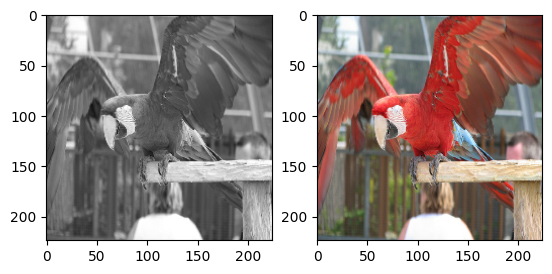

In [14]:
for batch in train_data.as_numpy_iterator():
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow((batch[0][0] + 1) * 127.5, cmap='gray', vmin=0, vmax=255)
    axs[1].imshow((batch[1][0] + 1) / 2)
    break

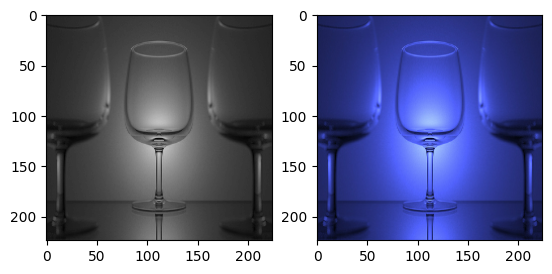

In [25]:
for batch in test_data.as_numpy_iterator():
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow((batch[0][0] + 1) * 127.5, cmap='gray', vmin=0, vmax=255)
    axs[1].imshow((batch[1][0] + 1) / 2)
    break

In [14]:
# with strategy.scope():
class encoder_block(tf.keras.Model):
    def __init__(self, filters=64, kernel_size=(3, 3), pool_size=2, padding='same'):
        super(encoder_block, self).__init__()
        self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='relu')
        self.conv_2 = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='relu')
        self.max_pool = MaxPooling2D(pool_size=pool_size)

    def call(self, inputs):
        x = self.conv_1(inputs)
        skip = self.conv_2(x)
        output = self.max_pool(skip)

        return skip, output

In [15]:
# with strategy.scope():
class decoder_block(tf.keras.Model):
    def __init__(self, filters=64, kernel_size=(3, 3), padding='same'):
        super(decoder_block, self).__init__()
        self.conv_t = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding=padding)
        self.concat = Concatenate()
        self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='relu')
        self.conv_2 = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='relu')

    def call(self, skip_input, inputs):
        upsample = self.conv_t(inputs)
        merged = self.concat([upsample, skip_input])
        x = self.conv_1(merged)
        output = self.conv_2(x)
        return output

## UNet Model Experimentation:

In [17]:
class UNet(tf.keras.Model):
    def __init__(self, input_size=(160, 160, 1), padding='same'):
        super(UNet, self).__init__()
        self.encoder_1 = encoder_block(filters=64)
        self.encoder_2 = encoder_block(filters=128)
        self.encoder_3 = encoder_block(filters=256)
        self.encoder_4 = encoder_block(filters=512)
        self.bottleneck_conv1 = Conv2D(filters=1024, kernel_size=(3, 3), activation='relu', padding=padding)
        self.bottleneck_conv2 = Conv2D(filters=1024, kernel_size=(3, 3), activation='relu', padding=padding)
        self.decoder_1 = decoder_block(filters=512)
        self.decoder_2 = decoder_block(filters=256)
        self.decoder_3 = decoder_block(filters=128)
        self.decoder_4 = decoder_block(filters=64)
        self.final_conv = Conv2D(filters=3, kernel_size=(1, 1), padding='same')

    def call(self, inputs):
        skip_4, x = self.encoder_1(inputs)
        skip_3, x = self.encoder_2(x)
        skip_2, x = self.encoder_3(x)
        skip_1, x = self.encoder_4(x)
        x = self.bottleneck_conv1(x)
        x = self.bottleneck_conv2(x)
        x = self.decoder_1(skip_1, x)
        x = self.decoder_2(skip_2, x)
        x = self.decoder_3(skip_3, x)
        x = self.decoder_4(skip_4, x)
        output = self.final_conv(x)
        return output

In [18]:
model = UNet()
model.compile(optimizer='adam', loss='mse', metrics=rms())

In [17]:
# model.summary()

2025-02-08 22:27:36.186415: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-02-08 22:27:36.271945: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


4/4 [==============================] - 3s 32ms/step
Model: "u_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_block (encoder_blo  multiple                  37568     
 ck)                                                             
                                                                 
 encoder_block_1 (encoder_b  multiple                  221440    
 lock)                                                           
                                                                 
 encoder_block_2 (encoder_b  multiple                  885248    
 lock)                                                           
                                                                 
 encoder_block_3 (encoder_b  multiple                  3539968   
 lock)                                                           
                                                                 
 conv2d_8

In [19]:
EPOCHS = 10

In [20]:
model.fit(train_data, epochs=EPOCHS, validation_data=val_data, verbose=2)

Epoch 1/10


2025-02-08 23:09:41.097710: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-02-08 23:09:41.186925: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-08 23:09:47.906520: I external/local_xla/xla/service/service.cc:168] XLA service 0x7a375f1a59e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-08 23:09:47.906544: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2025-02-08 23:09:47.906549: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2025-02-08 23:09:47.910648: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739036388.016429  551461 device_compiler.h:186] Co

20019/20019 - 11695s - loss: 0.0314 - root_mean_squared_error: 0.1771 - val_loss: 0.0305 - val_root_mean_squared_error: 0.1746 - 11695s/epoch - 584ms/step
Epoch 2/10
20019/20019 - 11577s - loss: 0.0304 - root_mean_squared_error: 0.1744 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1741 - 11577s/epoch - 578ms/step
Epoch 3/10
20019/20019 - 11577s - loss: 0.0302 - root_mean_squared_error: 0.1737 - val_loss: 0.0300 - val_root_mean_squared_error: 0.1731 - 11577s/epoch - 578ms/step
Epoch 4/10
20019/20019 - 11547s - loss: 77926.7031 - root_mean_squared_error: 279.1536 - val_loss: 0.0345 - val_root_mean_squared_error: 0.1856 - 11547s/epoch - 577ms/step
Epoch 5/10


KeyboardInterrupt: 

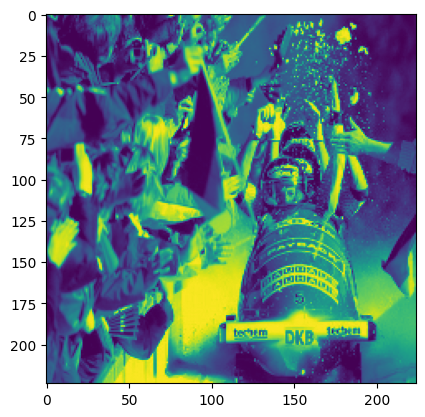

In [22]:
plt.imshow(batch[0][0])

In [31]:
results = model.predict(batch[0])

2/2 [==============================] - 0s 83ms/step


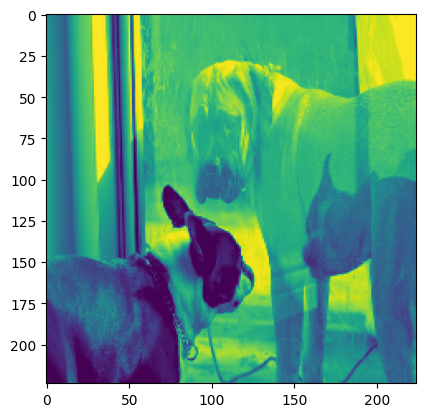

In [41]:
plt.imshow(batch[0][4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


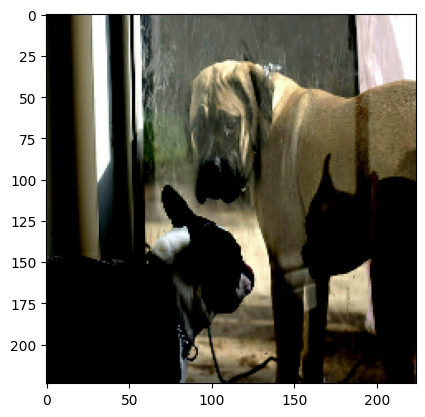

In [40]:
plt.imshow(batch[1][4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


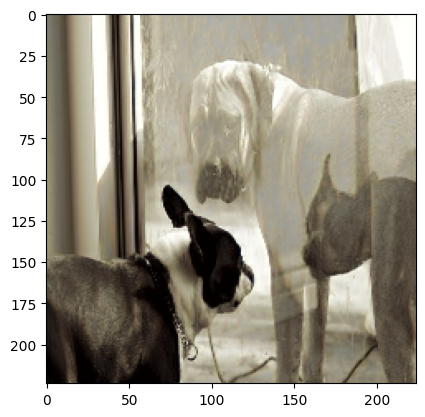

In [39]:
plt.imshow((results[4] + 1.0) / 2.0)

In [45]:
for batch in test_data.as_numpy_iterator():
    break

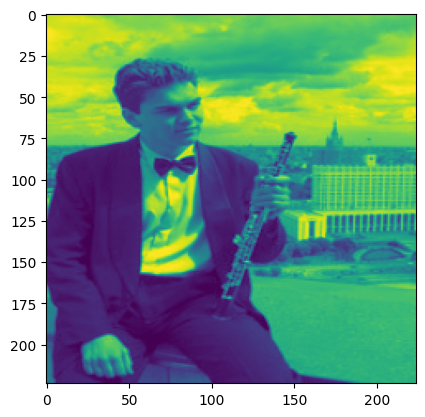

In [47]:
plt.imshow(batch[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


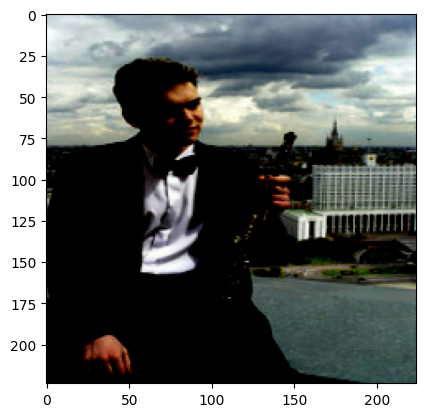

In [48]:
plt.imshow(batch[1][0])

In [49]:
results_test = model.predict(batch[0])

2/2 [==============================] - 0s 84ms/step


In [54]:
np.min((results_test[1] + 1) / 2)

-0.09921491

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


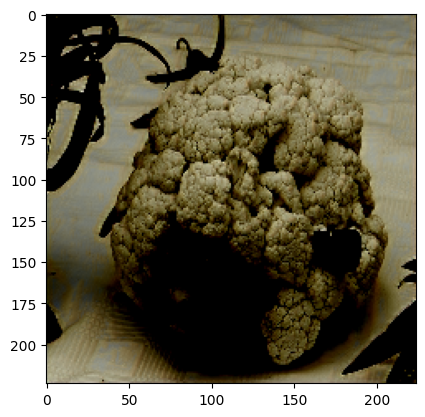

In [51]:
plt.imshow(results_test[1])

(160, 160, 1)


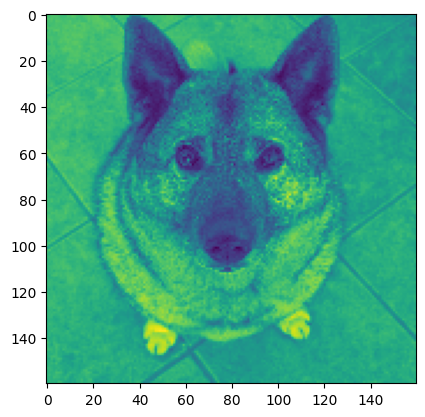

In [28]:
plt.imshow(batch[0][0])
print(batch[0][0].shape)

In [30]:
result = model.predict(batch[0])

4/4 [==============================] - 0s 44ms/step


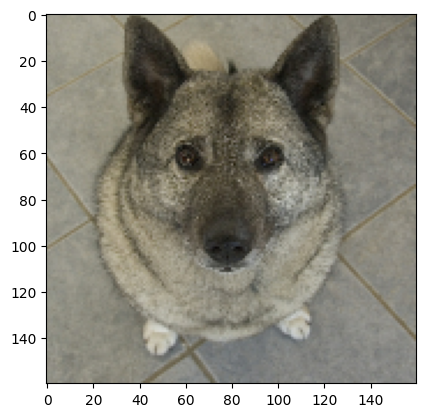

In [38]:
plt.imshow((batch[1][0] + 1) / 2)

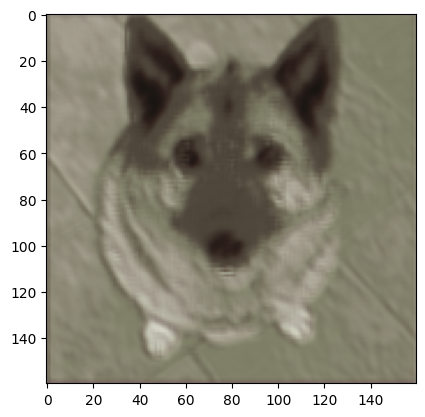

In [37]:
plt.imshow((result[0] + 1) / 2)

## Hypertuned UNet with Final Conv activation = Tanh

In [16]:
# with strategy.scope():
class UNet(tf.keras.Model):
    def __init__(self, padding='same'):
        super(UNet, self).__init__()
        self.encoder_1 = encoder_block(filters=64)
        self.encoder_2 = encoder_block(filters=128)
        self.encoder_3 = encoder_block(filters=256)
        # self.encoder_4 = encoder_block(filters=512)
        self.bottleneck_conv1 = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding=padding)
        self.bottleneck_conv2 = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding=padding)
        # self.decoder_1 = decoder_block(filters=512)
        self.decoder_2 = decoder_block(filters=256)
        self.decoder_3 = decoder_block(filters=128)
        self.decoder_4 = decoder_block(filters=64)
        self.final_conv = Conv2D(filters=3, kernel_size=(1, 1), padding='same', activation='tanh')

    def call(self, inputs):
        skip_4, x = self.encoder_1(inputs)
        skip_3, x = self.encoder_2(x)
        skip_2, x = self.encoder_3(x)
        # skip_1, x = self.encoder_4(x)
        x = self.bottleneck_conv1(x)
        x = self.bottleneck_conv2(x)
        # x = self.decoder_1(skip_1, x)
        x = self.decoder_2(skip_2, x)
        x = self.decoder_3(skip_3, x)
        x = self.decoder_4(skip_4, x)
        output = self.final_conv(x)
        return output

In [19]:
model = UNet()
model.compile(optimizer='adam', loss='mse', metrics=[rms()])

In [21]:
model.fit(val_data, epochs=5, verbose=2)

Epoch 1/5
782/782 - 400s - 512ms/step - loss: 0.0330 - root_mean_squared_error: 0.1816
Epoch 2/5
782/782 - 383s - 490ms/step - loss: 0.0324 - root_mean_squared_error: 0.1800
Epoch 3/5
782/782 - 382s - 489ms/step - loss: 0.0319 - root_mean_squared_error: 0.1786
Epoch 4/5
782/782 - 382s - 488ms/step - loss: 0.0315 - root_mean_squared_error: 0.1776
Epoch 5/5
782/782 - 382s - 488ms/step - loss: 0.0312 - root_mean_squared_error: 0.1766


In [26]:
results = model.predict(batch[0])

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


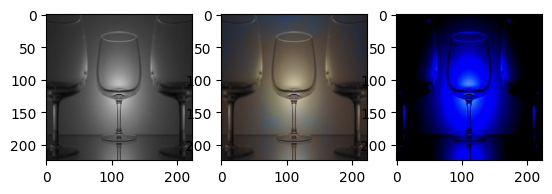

In [29]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow((batch[0][0] + 1) * 127.5, cmap='gray', vmin=0, vmax=255)
axs[1].imshow((results[0] + 1) / 2)
axs[2].imshow(batch[1][0])

Note: Hypertuned UNet with tanh as final activation provides better colouring, choosing this hypertuning decision

## Hypertuned UNet with callbacks:

In [17]:
tf.get_logger().setLevel('ERROR')

In [18]:
EPOCHS=10
model_checkpoint_callback = ModelCheckpoint(
    './unet_v2/checkpoint.weights.h5',
    monitor="val_root_mean_squared_error",
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    save_freq="epoch",
    initial_value_threshold=None,
)
def scheduler(epoch, lr):
    if (epoch <= 1):
        return 1e-4
    else:
        return lr
warmup_lr_cback = LearningRateScheduler(scheduler)

In [19]:
# Defining the custom Smooth Mean Absolute Error Loss (SMAE)
class smae(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
        
    def call(self, y_true, y_pred):
        e = y_true - y_pred
        tan = tf.math.tanh(e)
        final = tf.math.multiply(e, tan)
        return tf.math.reduce_mean(final)

    def __str__(self):
        return "SMAE"

In [20]:
# with strategy.scope():
model = UNet()
model.compile(optimizer='adam', loss='mse', metrics=[rms()])

In [21]:
# with strategy.scope():
model.fit(train_data, epochs=EPOCHS, 
          validation_data=val_data, verbose=2,
          callbacks=[model_checkpoint_callback])

Epoch 1/10


2025-02-16 18:59:56.706848: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-02-16 19:00:02.917069: I external/local_xla/xla/service/service.cc:168] XLA service 0x71fc235de260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-16 19:00:02.917093: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2025-02-16 19:00:02.917098: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2025-02-16 19:00:02.921189: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739712603.030964 1352035 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20019/20019 - 10103s - loss: 0.0310 - root_mean_squared_error: 0.1761 - val_loss: 0.0296 - val_root_mean_squared_error: 0.1722 - 10103s/epoch - 505ms/step
Epoch 2/10
20019/20019 - 10014s - loss: 0.0292 - root_mean_squared_error: 0.1709 - val_loss: 0.0287 - val_root_mean_squared_error: 0.1694 - 10014s/epoch - 500ms/step
Epoch 3/10
20019/20019 - 10010s - loss: 0.0286 - root_mean_squared_error: 0.1690 - val_loss: 0.0283 - val_root_mean_squared_error: 0.1681 - 10010s/epoch - 500ms/step
Epoch 4/10
20019/20019 - 10002s - loss: 0.0282 - root_mean_squared_error: 0.1678 - val_loss: 0.0279 - val_root_mean_squared_error: 0.1672 - 10002s/epoch - 500ms/step
Epoch 5/10
20019/20019 - 10000s - loss: 0.0279 - root_mean_squared_error: 0.1669 - val_loss: 0.0276 - val_root_mean_squared_error: 0.1662 - 10000s/epoch - 500ms/step
Epoch 6/10
20019/20019 - 9994s - loss: 0.0276 - root_mean_squared_error: 0.1662 - val_loss: 0.0274 - val_root_mean_squared_error: 0.1655 - 9994s/epoch - 499ms/step
Epoch 7/10
20019/

In [25]:
for batch in test_data.as_numpy_iterator():
    break

In [26]:
results = model.predict(batch[0])

2/2 [==============================] - 3s 6ms/step


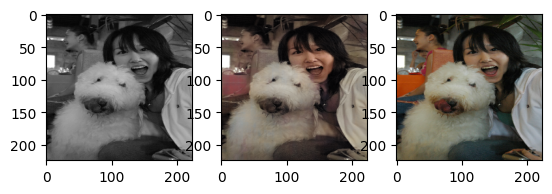

In [31]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow((batch[0][0] + 1) * 127.5, cmap='gray', vmin=0, vmax=255)
axs[1].imshow((results[0] + 1) / 2)
axs[2].imshow((batch[1][0] + 1) / 2)

In [32]:
model_checkpoint_callback = ModelCheckpoint(
    './unet_v2/checkpoint_cont.weights.h5',
    monitor="val_root_mean_squared_error",
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    save_freq="epoch",
    initial_value_threshold=None,
)

Note: Possible stagnation in below training loop due to loss of initial momentum

In [ ]:
history_cont = model.fit(train_data, epochs=EPOCHS, 
          validation_data=val_data, verbose=2,
          callbacks=[model_checkpoint_callback])

Epoch 1/10
20019/20019 - 9977s - loss: 0.0268 - root_mean_squared_error: 0.1638 - val_loss: 0.0269 - val_root_mean_squared_error: 0.1639 - 9977s/epoch - 498ms/step
Epoch 2/10
20019/20019 - 9987s - loss: 0.0267 - root_mean_squared_error: 0.1635 - val_loss: 0.0269 - val_root_mean_squared_error: 0.1640 - 9987s/epoch - 499ms/step
Epoch 3/10
20019/20019 - 9995s - loss: 0.0266 - root_mean_squared_error: 0.1632 - val_loss: 0.0268 - val_root_mean_squared_error: 0.1637 - 9995s/epoch - 499ms/step
Epoch 4/10
20019/20019 - 10001s - loss: 0.0265 - root_mean_squared_error: 0.1629 - val_loss: 0.0269 - val_root_mean_squared_error: 0.1639 - 10001s/epoch - 500ms/step
Epoch 5/10
20019/20019 - 9996s - loss: 0.0265 - root_mean_squared_error: 0.1626 - val_loss: 0.0270 - val_root_mean_squared_error: 0.1643 - 9996s/epoch - 499ms/step
Epoch 6/10
20019/20019 - 10000s - loss: 0.0264 - root_mean_squared_error: 0.1624 - val_loss: 0.0265 - val_root_mean_squared_error: 0.1628 - 10000s/epoch - 500ms/step
Epoch 7/10
2